## Part 1: Spark Programming Models

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import time
import os
from google import genai
import pandas as pd

In [ ]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.jsonl hdfs://nn:9000/
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [ ]:
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "1G")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/07 17:07:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
!hdfs dfs -cp data/problems.jsonl hdfs://nn:9000/problems.jsonl

cp: `hdfs://nn:9000/problems.jsonl': File exists


In [5]:
problems = spark.read.json("hdfs://nn:9000/problems.jsonl")

problems.printSchema()
problems.show(5)
problems = (spark.read.format("json")
             .option("header", True)
             .option("inferSchema", True)
             .load("hdfs://nn:9000/problems.jsonl").write.mode("overwrite").save("hdfs://nn:9000/problems.parquet"))
problems = spark.read.format("parquet").load("hdfs://nn:9000/problems.parquet")
problems.write.format("hive").mode("overwrite").saveAsTable("problems")

root
 |-- cf_contest_id: long (nullable = true)
 |-- cf_index: string (nullable = true)
 |-- cf_points: double (nullable = true)
 |-- cf_rating: long (nullable = true)
 |-- cf_tags: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- difficulty: long (nullable = true)
 |-- generated_tests: long (nullable = true)
 |-- is_description_translated: boolean (nullable = true)
 |-- memory_limit_bytes: long (nullable = true)
 |-- name: string (nullable = true)
 |-- private_tests: long (nullable = true)
 |-- problem_id: long (nullable = true)
 |-- public_tests: long (nullable = true)
 |-- source: long (nullable = true)
 |-- time_limit: long (nullable = true)



+-------------+--------+---------+---------+---------------+----------+---------------+-------------------------+------------------+--------------------+-------------+----------+------------+------+----------+
|cf_contest_id|cf_index|cf_points|cf_rating|        cf_tags|difficulty|generated_tests|is_description_translated|memory_limit_bytes|                name|private_tests|problem_id|public_tests|source|time_limit|
+-------------+--------+---------+---------+---------------+----------+---------------+-------------------------+------------------+--------------------+-------------+----------+------------+------+----------+
|          322|       A|    500.0|     1000|            [0]|         7|             93|                    false|         256000000|322_A. Ciel and D...|           45|         1|           2|     2|         1|
|          760|       D|   1000.0|     1600|         [1, 2]|        10|             51|                    false|         256000000|  760_D. Travel Card|       

25/11/07 17:08:17 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
25/11/07 17:08:17 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
25/11/07 17:08:21 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
25/11/07 17:08:21 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.2
25/11/07 17:08:22 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
25/11/07 17:08:24 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
25/11/07 17:08:24 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
25/11/07 17:08:24 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
25/11/07 17:08:24 W

In [6]:
!hdfs dfs -cp data/problems.jsonl hdfs://nn:9000/solutions.jsonl


cp: `hdfs://nn:9000/solutions.jsonl': File exists


In [7]:
solutions = spark.read.json("hdfs://nn:9000/solutions.jsonl")

solutions.show(5)

solutions = (spark.read.format("json")
             .option("header", True)
             .option("inferSchema", True)
             .load("hdfs://nn:9000/solutions.jsonl").write.mode("overwrite").save("hdfs://nn:9000/solutions.parquet"))
solutions = spark.read.format("parquet").load("hdfs://nn:9000/solutions.parquet")
solutions.write.mode("overwrite").bucketBy(4, "language").saveAsTable("solutions")

+----------+--------+----------+--------------------+
|is_correct|language|problem_id|            solution|
+----------+--------+----------+--------------------+
|      true| PYTHON2|         1|n,m = [int(nm) fo...|
|      true| PYTHON2|         1|mn = map(int, raw...|
|      true| PYTHON2|         1|n,m=map(int, raw_...|
|      true|    JAVA|         1|import java.io.Bu...|
|      true|    JAVA|         1|import java.util....|
+----------+--------+----------+--------------------+
only showing top 5 rows



In [8]:
!hdfs dfs -ls hdfs://nn:9000/

Found 13 items
-rw-r--r--   1 root supergroup         75 2025-11-07 17:07 hdfs://nn:9000/languages.csv
drwxr-xr-x   - root supergroup          0 2025-11-07 16:41 hdfs://nn:9000/languages.parquet
-rw-r--r--   1 root supergroup   12731821 2025-11-07 17:07 hdfs://nn:9000/problem_tests.csv
drwxr-xr-x   - root supergroup          0 2025-11-07 16:41 hdfs://nn:9000/problem_tests.parquet
-rw-r--r--   1 root supergroup    2854960 2025-11-07 17:07 hdfs://nn:9000/problems.jsonl
drwxr-xr-x   - root supergroup          0 2025-11-07 17:08 hdfs://nn:9000/problems.parquet
-rw-r--r--   1 root supergroup  177825918 2025-11-07 17:07 hdfs://nn:9000/solutions.jsonl
drwxr-xr-x   - root supergroup          0 2025-11-07 17:08 hdfs://nn:9000/solutions.parquet
-rw-r--r--   1 root supergroup        101 2025-11-07 17:07 hdfs://nn:9000/sources.csv
drwxr-xr-x   - root supergroup          0 2025-11-07 16:41 hdfs://nn:9000/sources.parquet
-rw-r--r--   1 root supergroup        555 2025-11-07 17:07 hdfs://nn:9000/tags.

In [9]:
datasets = ["languages", "problem_tests", "sources", "tags"]

for name in datasets:

    path = f"hdfs://nn:9000/{name}.csv"


    df = (
        spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load(path)
    )
    cols = [col(c).alias(c.replace("_", "_")) for c in df.columns]
    df.select(cols).write.format("parquet").mode("overwrite").save(f"hdfs://nn:9000/{name}.parquet")
    df = spark.read.format("parquet").load(f"hdfs://nn:9000/{name}.parquet")

  
    df.createOrReplaceTempView(name)
    
languages = spark.table("languages")
sources = spark.table("sources")
problem_tests = spark.table("problem_tests")
tags = spark.table("tags")



In [10]:
!hdfs dfs -rm hdfs://nn:9000/languages.csv
!hdfs dfs -rm hdfs://nn:9000/problem_tests.csv
!hdfs dfs -rm hdfs://nn:9000/sources.csv
!hdfs dfs -rm hdfs://nn:9000/tags.csv

Deleted hdfs://nn:9000/languages.csv
Deleted hdfs://nn:9000/problem_tests.csv
Deleted hdfs://nn:9000/sources.csv
Deleted hdfs://nn:9000/tags.csv


In [11]:
!hdfs dfs -ls -h hdfs://nn:9000/

Found 9 items
drwxr-xr-x   - root supergroup          0 2025-11-07 17:08 hdfs://nn:9000/languages.parquet
drwxr-xr-x   - root supergroup          0 2025-11-07 17:09 hdfs://nn:9000/problem_tests.parquet
-rw-r--r--   1 root supergroup      2.7 M 2025-11-07 17:07 hdfs://nn:9000/problems.jsonl
drwxr-xr-x   - root supergroup          0 2025-11-07 17:08 hdfs://nn:9000/problems.parquet
-rw-r--r--   1 root supergroup    169.6 M 2025-11-07 17:07 hdfs://nn:9000/solutions.jsonl
drwxr-xr-x   - root supergroup          0 2025-11-07 17:08 hdfs://nn:9000/solutions.parquet
drwxr-xr-x   - root supergroup          0 2025-11-07 17:09 hdfs://nn:9000/sources.parquet
drwxr-xr-x   - root supergroup          0 2025-11-07 17:09 hdfs://nn:9000/tags.parquet
drwxr-xr-x   - root supergroup          0 2025-11-06 21:53 hdfs://nn:9000/user


In [12]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|     problems|      false|
|  default|    solutions|      false|
|         |    languages|       true|
|         |problem_tests|       true|
|         |      sources|       true|
|         |         tags|       true|
+---------+-------------+-----------+



In [13]:
spark.sql("DESCRIBE problemS").show()

+--------------------+-------------+-------+
|            col_name|    data_type|comment|
+--------------------+-------------+-------+
|       cf_contest_id|       bigint|   NULL|
|            cf_index|       string|   NULL|
|           cf_points|       double|   NULL|
|           cf_rating|       bigint|   NULL|
|             cf_tags|array<bigint>|   NULL|
|          difficulty|       bigint|   NULL|
|     generated_tests|       bigint|   NULL|
|is_description_tr...|      boolean|   NULL|
|  memory_limit_bytes|       bigint|   NULL|
|                name|       string|   NULL|
|       private_tests|       bigint|   NULL|
|          problem_id|       bigint|   NULL|
|        public_tests|       bigint|   NULL|
|              source|       bigint|   NULL|
|          time_limit|       bigint|   NULL|
+--------------------+-------------+-------+



#### Q1: How many problems are there with a `cf_rating` of at least 1600, having `private_tests`, and a name containing "_A." (Case Sensitive)? Answer using all three Spark APIs.

In [14]:
problems = spark.table("problems")
solutions = spark.table("solutions")

In [15]:
#q1

## RDD API
rddct = (problems.rdd.filter(lambda row: row.cf_rating >= 1600 and
                        row.private_tests > 0 and
                        "_A." in row.name)
    .count())
## DataFrame API
dfcount = (problems
 .where((col("cf_rating") >= 1600) & (col("private_tests") > 0) & (col("name").contains("_A.")))
 .count())

## Spark SQL API
sqlct = spark.sql("""SELECT * FROM problems
            WHERE cf_rating >=1600 AND private_tests > 0 AND name LIKE UPPER('%_A.%') """).count()
(rddct, dfcount, sqlct)

(217, 217, 217)

#### Q2: How many correct PYTHON3 solutions are from CODEFORCES?

In [16]:
spark.sql("SELECT * FROM SOURCES LIMIT 3").show(
)

+------+--------------+
|source|   source_name|
+------+--------------+
|     0|UNKNOWN_SOURCE|
|     1|      CODECHEF|
|     2|    CODEFORCES|
+------+--------------+



In [17]:
#q2
spark.sql("""
SELECT * FROM SOLUTIONS r
INNER JOIN PROBLEMS l ON r.problem_id = l.problem_id
WHERE language = 'PYTHON3' AND is_correct IS TRUE AND SOURCE = (
    SELECT SOURCE FROM SOURCES
    WHERE source_name = 'CODEFORCES'
)""").count()

10576

#### Q3: How many problems are of easy/medium/hard difficulty?


In [18]:
#q3
q3 = spark.sql("""
SELECT
    (CASE
        WHEN difficulty <= 5 THEN 'Easy'
        WHEN difficulty <= 10 THEN 'Medium'
        WHEN difficulty > 10 THEN 'Hard'
     END) AS difficult, COUNT(*) AS C
FROM PROBLEMS
GROUP BY difficult
""").toPandas()
dict(zip(q3['difficult'], q3['C']))

{'Easy': 409, 'Medium': 5768, 'Hard': 2396}

#### Q4: What tables/views are in our warehouse?

In [19]:
#q4
q4 = spark.sql("SHOW TABLES").toPandas()
dict(zip(q4['tableName'], q4['isTemporary']))

{'problems': False,
 'solutions': False,
 'languages': True,
 'problem_tests': True,
 'sources': True,
 'tags': True}

## Part 2: Performance Analysis

#### Q5: Does the query plan for a GROUP BY on solutions data need to shuffle/exchange rows if the data is pre-bucketed?

In [20]:
#q5
spark.sql("SELECT language, COUNT(*) FROM solutions GROUP BY language").explain("formatted")


== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.solutions (1)


(1) Scan parquet spark_catalog.default.solutions
Output [1]: [language#653]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/solutions]
ReadSchema: struct<language:string>
SelectedBucketsCount: 4 out of 4

(2) HashAggregate
Input [1]: [language#653]
Keys [1]: [language#653]
Functions [1]: [partial_count(1)]
Aggregate Attributes [1]: [count#844L]
Results [2]: [language#653, count#845L]

(3) HashAggregate
Input [2]: [language#653, count#845L]
Keys [1]: [language#653]
Functions [1]: [count(1)]
Aggregate Attributes [1]: [count(1)#840L]
Results [2]: [language#653, count(1)#840L AS count(1)#841L]

(4) AdaptiveSparkPlan
Output [2]: [language#653, count(1)#841L]
Arguments: isFinalPlan=false




#### Q6: Does caching make it faster to compute averages over a subset of a bigger dataset?

To test the impact of caching, we are going to do the same calculations with and without caching.

In [ ]:
#q6

filtered = spark.table("problem_tests").filter("is_generated = false")

def timed_avg(df):
    start = time.time()
    df.selectExpr("avg(input_chars)", "avg(output_chars)").collect()
    end = time.time()
    duration = end - start
    return duration


t1 = timed_avg(filtered)
filtered.cache()
t2 = timed_avg(filtered)
t3 = timed_avg(filtered)
filtered.unpersist()

[t1, t2, t3]


[0.795534610748291, 2.310716390609741, 0.40144777297973633]

## Part 3: Spark and Generative AI

In this part, you'll build a natural language interface to your Spark data using the Gemini API. You'll create a function that converts English questions into executable Spark SQL queries that you will automatically run.

Implement the `human_query` function, which takes a string, and returns a single numeric result (as an int)

#### Q7: How many JAVA solutions are there?

In [ ]:
#q7

client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

def human_query(question):
    tbl_schemas = []
    for tbl in spark.catalog.listTables():
        tbl_name = tbl.name
        cols = spark.catalog.listColumns(tbl_name)
        schema_str = f"Table: {tbl_name}\n" + "\n".join(
            [f" - {c.name} ({c.dataType})" for c in cols])
        
        tbl_schemas.append(schema_str)
    
    schema_info = "\n\n".join(tbl_schemas)

    prompt = f"""
You are a data assistant that converts English questions into Spark SQL queries.

The following tables and schemas are available in Spark:

{schema_info}

Question: {question}

Requirements:
- Return only a single valid Spark SQL query.
- Do NOT include markdown, code blocks, or explanations.
- Use only the columns and tables provided above.
- The query must return exactly one numeric value.
"""

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt,
        config={"temperature": 0},  # deterministic output
    )

    sql_query = response.text.strip()
    result = spark.sql(sql_query).collect()[0][0]

    return int(result)

q7_result = human_query("How many JAVA solutions are there?")
print(q7_result)

28722


#### Q8: What is the maximum memory limit in bytes?

In [28]:
#q8
q8_result = human_query("What is the maximum memory limit in bytes?")
print(q8_result)

1024000000


## Part 4: Spark and Traditional Machine Learning

The dataset documentation for the `difficulty` field says: "For Codeforces problems, cf_rating is a more reliable measure of difficulty when available".

For this part, you will attempt to estimate the cf_rating for Codeforces problems for which it is unknown. To prepare, filter the problems to `CODEFORCES` problems, then further divide into three DataFrames:

- train dataset: `cf_rating` is >0, and `problem_id` in an EVEN number
- test dataset: `cf_rating` is >0, and `problem_id` in an ODD number
- missing dataset: `cf_rating` is 0

#### Q9: Do the problems with a missing `cf_score` appear more or less challenging that other problems?

Create a Spark Pipeline model with VectorAssembler and DecisionTreeRegression stages. The max tree depth should be 5. Train it on the training data, using `cf_score` for the label and the following for the features: `difficulty`, `time_limit` and `memory_limit_bytes`.

Use your model to predict the `cf_score` in the dataset where it is missing.

Answer with a tuple with 3 numbers:

- average `cf_rating` in the training dataset
- average `cf_rating` in the test dataset
- average **prediction** of `cf_rating` in the missing dataset

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [39]:
problems.printSchema()
problems.show(5)

root
 |-- cf_contest_id: long (nullable = true)
 |-- cf_index: string (nullable = true)
 |-- cf_points: double (nullable = true)
 |-- cf_rating: long (nullable = true)
 |-- cf_tags: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- difficulty: long (nullable = true)
 |-- generated_tests: long (nullable = true)
 |-- is_description_translated: boolean (nullable = true)
 |-- memory_limit_bytes: long (nullable = true)
 |-- name: string (nullable = true)
 |-- private_tests: long (nullable = true)
 |-- problem_id: long (nullable = true)
 |-- public_tests: long (nullable = true)
 |-- source: long (nullable = true)
 |-- time_limit: long (nullable = true)

+-------------+--------+---------+---------+---------------+----------+---------------+-------------------------+------------------+--------------------+-------------+----------+------------+------+----------+
|cf_contest_id|cf_index|cf_points|cf_rating|        cf_tags|difficulty|generated_tests|is_description_transla

In [ ]:
#q9

codeforces_df = problems.filter(problems.source == 2)
train_df = codeforces_df.filter((col("cf_rating") > 0) & (col("problem_id") % 2 == 0))
test_df = codeforces_df.filter((col("cf_rating") > 0) & (col("problem_id") % 2 != 0))
missing_df = codeforces_df.filter(col("cf_rating") == 0)

assembler = VectorAssembler(
    inputCols=["difficulty", "time_limit", "memory_limit_bytes"],
    outputCol="features")

dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="cf_rating",
    maxDepth=5)

pipeline = Pipeline(stages=[assembler, dt])
model = pipeline.fit(train_df)

predictions = model.transform(missing_df)

train_avg = train_df.agg({"cf_rating": "avg"}).collect()[0][0]
test_avg = test_df.agg({"cf_rating": "avg"}).collect()[0][0]
missing_avg_pred = predictions.agg({"prediction": "avg"}).collect()[0][0]

(train_avg, test_avg, missing_avg_pred)



(1887.9377431906614, 1893.1106471816283, 1950.47286388188)

#### Q10: How does tree depth impact the quality of predictions?

Collect the depth and R^2 results from your experiment in a Pandas DataFrame with
these columns: `depth`, `train`, `test`.  Use this data to create a plot.

Additionally, call `.to_json()` on your plot DataFrame to get a string
representation of the data.

The output for your Q10 cell should be both the plot image and the
JSON string.

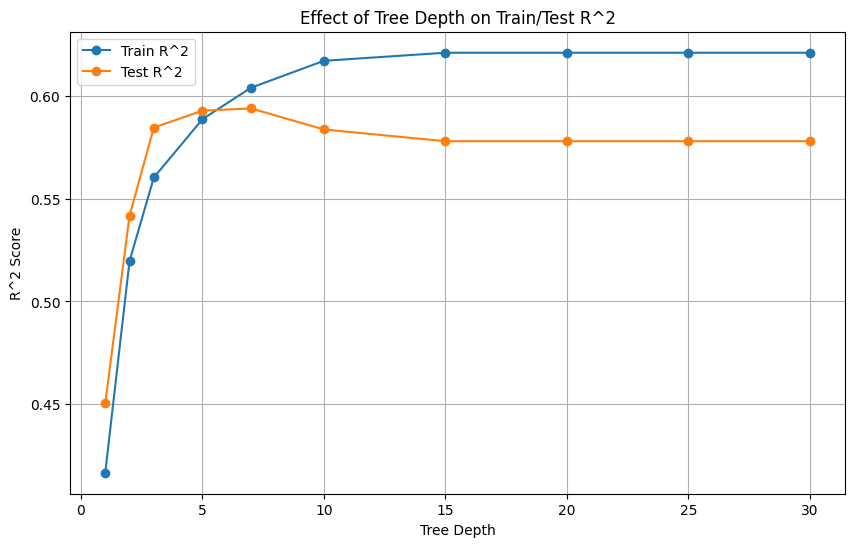

'{"depth":{"0":1,"1":2,"2":3,"3":5,"4":7,"5":10,"6":15,"7":20,"8":25,"9":30},"train":{"0":0.4165232341,"1":0.5196985669,"2":0.5604188787,"3":0.5888249718,"4":0.6041716987,"5":0.6172907631,"6":0.6212285845,"7":0.6212285845,"8":0.6212285845,"9":0.6212285845},"test":{"0":0.4503904026,"1":0.5418856179,"2":0.5847461912,"3":0.5929835263,"4":0.5940872453,"5":0.5838230167,"6":0.5780981739,"7":0.5780981739,"8":0.5780981739,"9":0.5780981739}}'

In [ ]:
#q10
feature_cols = ["difficulty", "time_limit", "memory_limit_bytes"]

assembler = VectorAssembler(inputCols = feature_cols, outputCol = "features")

depths = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30]

evaluator = RegressionEvaluator(labelCol = "cf_rating", predictionCol = "prediction", metricName = "r2")

train_r2_list = []
test_r2_list = []

for d in depths:
    dt = DecisionTreeRegressor(labelCol = "cf_rating", featuresCol="features", maxDepth = d)
    
    pipeline = Pipeline(stages=[assembler, dt])
    model = pipeline.fit(train_df)
    
    train_pred = model.transform(train_df)
    test_pred = model.transform(test_df)
    train_r2 = evaluator.evaluate(train_pred)
    test_r2 = evaluator.evaluate(test_pred)
    
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

plot_df = pd.DataFrame({
    "depth": depths,
    "train": train_r2_list,
    "test": test_r2_list})

plt.figure(figsize = (10,6))
plt.plot(plot_df["depth"], plot_df["train"], label="Train R^2", marker='o')
plt.plot(plot_df["depth"], plot_df["test"], label="Test R^2", marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("R^2 Score")
plt.title("Effect of Tree Depth on Train/Test R^2")
plt.legend()
plt.grid(True)
plt.show()

plot_json = plot_df.to_json()
plot_json

